In [53]:
import os

openai_api_key=os.getenv("openai_api_key")
AZURE_OPENAI_DEPLOYMENT_NAME = os.getenv('deployment_name')
AZURE_OPENAI_ENDPOINT = os.getenv("endpoint")
AZURE_OPENAI_API_VERSION = os.getenv("version")

In [54]:
from langchain.chat_models import AzureChatOpenAI

llm= AzureChatOpenAI(
    deployment_name=AZURE_OPENAI_DEPLOYMENT_NAME,
    openai_api_base=AZURE_OPENAI_ENDPOINT,
    openai_api_key=openai_api_key,
    openai_api_version=AZURE_OPENAI_API_VERSION
)

d:\Yash-Python\Lib\site-packages\langchain_community\chat_models\azure_openai.py:174: UserWarning: As of openai>=1.0.0, Azure endpoints should be specified via the `azure_endpoint` param not `openai_api_base` (or alias `base_url`). Updating `openai_api_base` from https://soa-openai-sc.openai.azure.com/ to https://soa-openai-sc.openai.azure.com/openai.
  warnings.warn(
d:\Yash-Python\Lib\site-packages\langchain_community\chat_models\azure_openai.py:181: UserWarning: As of openai>=1.0.0, if `deployment_name` (or alias `azure_deployment`) is specified then `openai_api_base` (or alias `base_url`) should not be. Instead use `deployment_name` (or alias `azure_deployment`) and `azure_endpoint`.
  warnings.warn(
d:\Yash-Python\Lib\site-packages\langchain_community\chat_models\azure_openai.py:189: UserWarning: As of openai>=1.0.0, if `openai_api_base` (or alias `base_url`) is specified it is expected to be of the form https://example-resource.azure.openai.com/openai/deployments/example-deployme

In [55]:
from langchain_core.tools import Tool
from langchain_google_community import GoogleSearchAPIWrapper

search = GoogleSearchAPIWrapper(
    k=2
)

google_search = Tool(
    name="google_search",
    func=search.run,
    description="Search Engine",
    max_tokens=500
)

In [56]:
from typing import List, Dict, Optional
from pydantic import BaseModel, Field, validator

class Enrich(BaseModel):
    Product: str = Field(description="Name/Type of the product in the query", default="N/A")
    Dimension: str = Field(description="Dimension of product", default="N/A")
    Enriched_Query: str = Field(description="Reformulate the user query into a well-defined and detailed format", default="N/A")

class Valid_1(BaseModel):
    status: bool = Field(description="Validation status either true/false", default=False)
    suggestion: str = Field(description="If status is True, provide detailed improvement suggestions. If status is False, write N/A", default="N/A")

class MatchResult(BaseModel):
    Product: bool = Field(description="Does product matched, true or false.", default=False)
    Dimension: bool = Field(description="Does dimension of product matched, true or false.", default=False)

class ProductDetails(BaseModel):
    Product_id: str=Field(description="Product id")
    description: str=Field(description="Description of the product")
    Matching_Numerical_Entities: Optional[int] = Field(description="Number of Matching Numerical Entities", default=0)
    Matching_Non_Numerical_Entities: Optional[int] = Field(description="Number of matched non-numerical entities", default=0)

class Product(BaseModel):
    Product_id: Optional[str]
    Manufacturer_Part_No: Optional[str] = Field(alias="Manufacturer Part No. ")
    description: Optional[str]
    stock_type: Optional[int]
    additional_information: Optional[Dict[str, str]]=Field(default_factory={})

class num_nnum(BaseModel):
    Numerical_Entities: Optional[List[str]] = Field(
        description="list of the numerical entities",
        default_factory=list
    )
    Non_Numerical_Entities: Optional[List[str]] = Field(
        description="list of non-numerical entities",
        default_factory=list
    )

class State(BaseModel):
    query: Optional[str]=Field(default=" ")
    context: Optional[str]=Field(default=" ")
    output_1: Optional[Enrich]=Field(default_factory=Enrich)
    valid: Valid_1=Field(default_factory=Valid_1)
    entities:Optional[num_nnum]=Field(default_factory=num_nnum)
    # products_list: List[Product]
    # t_n_f_list: Optional[List[MatchResult]]
    # output_2: Optional[List[ProductDetails]]

In [57]:
check=State()
check

State(query=' ', context=' ', output_1=Enrich(Product='N/A', Dimension='N/A', Enriched_Query='N/A'), valid=Valid_1(status=False, suggestion='N/A'), entities=num_nnum(Numerical_Entities=[], Non_Numerical_Entities=[]))

In [58]:
def demo(state:State):
    val=state.valid
    return val

In [59]:
# state=State()
# print(demo(state))

In [60]:
def google(state:State)->str:
    return {"context":google_search.invoke(state.query)}

In [61]:
from langchain_core.output_parsers import JsonOutputParser
from langchain_core.prompts import PromptTemplate

In [62]:
# google_search.invoke("2 in x 2 in x 3/4 in thrd tee C.S")

In [63]:
def query_enrich(state: State)->Dict[str,str]:
    system_prompt = """
        You are given a product description along with some context. Your task is to extract relevant information and return it as a structured. It should include fields such as the product's quantity, name, and no additional details that can be inferred from the context.
        Only give the output, no description is needed.
        You are also provided with the possible changes that should be made while giving output.
        
        Query:{query}
        Context:{context}
        Suggestion:{suggest}

        Output:
        Product:(Name/Type of the product in the query),
        Dimension:(Dimension of product),
        Enriched_Query:(Reformulate the user query into a well-defined and detailed format by utilizing both the query and the provided context.),

        MUST INCLUDE THESE THREE PARAMETERS IN OUTPUT.
        In {format}
        """

    parser = JsonOutputParser(pydantic_object=Enrich)

    prompt = PromptTemplate(
        template=system_prompt,
        input_variables=["query","context","suggest"],
        partial_variables={"format": parser.get_format_instructions()},
    )
    chain = prompt | llm | parser

    # Get the response as a Pydantic model
    response = chain.invoke({
        "query":state.query,
        "context":state.context,
        "suggest":state.valid.suggestion
    })

    return {"output_1": response}

In [64]:
def valid_1(state: State)->Dict[str,str]:
    system_prompt = """
        You are an expert Supervisor Model tasked with evaluating the quality of outputs generated by an AI agent. Your responsibilities include:
        1. Checking if the output meets the specified expectations.
        2. Providing actionable feedback if the output deviates from expectations.

        ### Evaluation Criteria:
        - **Status**:
        - Mark `status` as **True** if the output does not meet the expectations, and provide improvement suggestions.
        - Mark `status` as **False** if the output aligns with expectations, and write "N/A" in the `suggestion` field.

        ### Expectations:
        The output should:
        1. Extract relevant information from the input query and context.
        2. Return the information in a **structured format**, including the following fields:
        - **Product**: The name or type of the product mentioned in the query.
        - **Dimension**: The dimensions of the product, if provided in the context.
        - **Enriched_Query**: A reformulated version of the user query that is well-defined, detailed, and utilizes both the query and context.
        3. Avoid including additional or inferred details not explicitly mentioned in the query or context.

        ### Input Details:
        - **Query**: {query}
        - **Context**: {context}

        ### AI Agent's Output:
        - **Output**: {output}

        ### Required Output:
        You must return:
        status: (True/False) — Whether the output meets expectations.
        suggestion: (If `status` is True, provide detailed improvement suggestions. If `status` is False, write "N/A".)

        Format:{format}
"""

    parser = JsonOutputParser(pydantic_object=Valid_1)

    prompt = PromptTemplate(
        template=system_prompt,
        input_variables=["query","context","output"],
        partial_variables={"format": parser.get_format_instructions()},
    )
    chain = prompt | llm | parser

    # Get the response as a Pydantic model
    response = chain.invoke({
        "query":state.query,
        "context":state.context,
        "output":state.output_1
    })   
    # state.valid=response
    return {"valid":response}


In [65]:
def condition_1(state:State)->str:
    if state.valid.status:
        return "repeat"
    return "next"

In [66]:
def entity(state:State)->Dict[str,str]:
    system_prompt = """
        You are an expert data analyzer. Your task is to extract and classify entities from a given query into two categories: **numerical entities** and **non-numerical entities**.You can also refer to suggestion provided by the validator to give the similar output. Provide the results strictly in the following format below:

        General list of numerical entities:
        - Amount 
        - Count 
        - Percentage 
        - Date 
        - Time 
        - Distance 
        - Quantity 
        - Rate 
        - Rank 
        - Size 
        - ID Number
        - Dimension

        General list of non-numerical entities:
        - Organization 
        - Person 
        - Location 
        - Product 
        - Service 
        - Event 
        - Process 
        - Category 
        - Attribute 
        - Keyword 
        - Industry 

        Input Query: 
        Original user query:{query}
        Enriched user query:{enrich_query}
        Suggestion:{suggest}

        Output:
        Numerical_Entities: list of numerical entities present in the Input (Use N/A if not found)
        Non_Numerical_Entities: list of unique non-numerical entities present in the Input(Use N/A if not found)

        ### Example:

        Input Query: 
        Original user query: 10 2-2-3/4 threaded tee C.S 
        Enriched user query: 10 quantities of 2-inch by 2-inch by 3/4-inch threaded tee fitting made of carbon steel (C.S.)

        Output:
        Numerical_Entities: [10, 2-inch by 2-inch by 3/4-inch],
        Non_Numerical_Entities: ["threaded tee fitting", "carbon steel"]

        ONLY GIVE OUTPUT. DO NOT INCLUDE EXTRA INFORMATION, SYMBOLS, OR TEXT.
        {format}
    """
    parser=JsonOutputParser(pydantic_object=num_nnum)
    prompt=PromptTemplate(
        template=system_prompt,
        input_variables=["query","enrich_query","suggest"],
        partial_variables={"format":parser.get_format_instructions()}
    )

    chain=prompt | llm | parser

    response=chain.invoke({
        "query":state.query,
        "enrich_query":state.output_1.Enriched_Query,
        "suggest":state.valid.suggestion
    })
    return {"entities":response}


In [67]:
def valid_2(state:State)->str:
    system_prompt = """
        You are a Supervisor Model evaluating the quality of an AI agent's output. Your tasks are to:
        1. Verify if the output meets expectations.
        2. Provide actionable feedback if it deviates from expectations.

        ### Evaluation Criteria:
        **Status**: 
        - Set to **True** if the output does not meet expectations, and provide improvement suggestions (examples are allowed).
        - Set to **False** if the output meets expectations, and write "N/A" in `suggestion`.

        ### Expectations:
            General list of numerical entities:
            - Amount 
            - Count 
            - Percentage 
            - Date 
            - Time 
            - Distance 
            - Quantity 
            - Rate 
            - Rank 
            - Size 
            - ID Number
            - Dimension

            General list of non-numerical entities:
            - Organization 
            - Person 
            - Location 
            - Product 
            - Service 
            - Event 
            - Process 
            - Category 
            - Attribute 
            - Keyword 
            - Industry 
            
            For example
            - Numerical_Entities: [10, 2-inch by 2-inch by 3/4-inch],
            - Non_Numerical_Entities: ["threaded tee fitting", "carbon steel"]

        ### Inputs:
        - **User Query**: {query}
        - **Enriched Query**: {context}
        - **AI Output**: {output}

        ### Required Output:
        - `status`: True (if the output deviates) or False (if it meets expectations).
        - `suggestion`: Detailed feedback if `status` is True; "N/A" if `status` is False.

        Output Format: {format}
"""


    parser = JsonOutputParser(pydantic_object=Valid_1)

    prompt = PromptTemplate(
        template=system_prompt,
        input_variables=["query","context","output"],
        partial_variables={"format": parser.get_format_instructions()},
    )
    chain = prompt | llm | parser

    # Get the response as a Pydantic model
    response = chain.invoke({
        "query":state.query,
        "context":state.output_1.Enriched_Query,
        "output":state.entities
    })   
    # state.valid=response
    # response['status']=False
    return {"valid":response}

In [68]:
from langgraph.graph import StateGraph, START, END

graph_builder = StateGraph(State)

graph_builder.add_node("search", google)
graph_builder.add_node("enrichment", query_enrich)
graph_builder.add_node("validator_1", valid_1)
graph_builder.add_node("entity",entity)
graph_builder.add_node("validator_2",valid_2)
graph_builder.add_edge(START, "search")
graph_builder.add_edge("search", "enrichment")
graph_builder.add_edge("enrichment","validator_1")
# graph_builder.add_edge("validator",END)
graph_builder.add_conditional_edges(
    "validator_1",
     condition_1, 
    {
        "repeat": "enrichment",
        "next": "entity"
    }
)
graph_builder.add_edge("entity","validator_2")
graph_builder.add_conditional_edges(
    "validator_2",
     condition_1, 
    {
        "repeat": "entity",
        "next": END
    }
)

In [69]:
graph=graph_builder.compile()

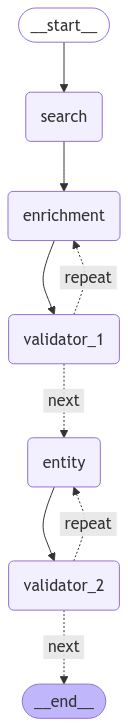

In [70]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:

    pass

In [71]:
user_input="3 in(inch) schedule sch(schedule) 10 316 90s(90 short radius) 90 degree elbow"

In [72]:
# user_input="Hello how are you!"

In [73]:
context_data=[
    {
        "Product_id": "75fnte",
        "Manufacturer Part No. ": "75fnte",
        "description": "lock nut thin nylon insert measurement system imperial 3/4 - 16 thread",
        "stock_type": 1,
        "additional_information": {}
    }]

In [74]:
from langgraph.errors import GraphRecursionError

try:
    response = graph.invoke(
        {
            "query": user_input,
            "valid": Valid_1(status=True, suggestion="No no"),
            # "products_list": context_data
        },
        {"recursion_limit": 10}  # Set recursion limit here
    )
except GraphRecursionError:
    print("Recursion Error")

In [75]:
response['output_1']

{'Product': '90 degree elbow',
 'Dimension': '3 inch',
 'Enriched_Query': '3 inch schedule 10 316 stainless steel 90 degree short radius elbow'}

In [76]:
response['valid']

{'status': False, 'suggestion': 'N/A'}

In [77]:
response['entities']

{'Numerical_Entities': ['3 inch', 'schedule 10', '90 degree'],
 'Non_Numerical_Entities': ['316 stainless steel', 'short radius elbow']}